In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
import bokeh
from bokeh.plotting import figure, output_file, show, ColumnDataSource
# import bokeh.charts.utils
import bokeh.io
import bokeh.models
from bokeh.models import HoverTool
import bokeh.palettes
import bokeh.plotting
import random
from random import sample

In [3]:
# Preprocessing, normalization done in excel (Xnew = (X-mean)/std))
# If we want to normalize in Python we can use preprocessing.scale()
Data = pd.read_csv('songs4.csv')
Data = Data.iloc[:, 0:18]
#Data = Data.drop(Data[(Data.time_signature > 5)].index)
Data.head()

,ID,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,zero_ts,one_ts,three_ts,four_ts,five_ts
0,5CQ30WqJwcep0pYcV4AMNc,-1.268543,-0.885605,1.050276,-0.280775,-1.258128,-0.630077,0.678645,-0.649848,-0.480625,-1.032112,-1.205528,1.347462,-0.040332,-0.105962,-0.314267,0.378598,-0.152588
1,0yE62JSC9J9C4Q4OBMwBgA,-0.385007,-0.303138,1.050276,0.009403,0.794818,2.212337,-0.630163,-0.658555,-0.504163,-0.175880,-0.772431,-0.113739,-0.040332,-0.105962,3.181954,-2.641279,-0.152588
2,66v8ihTuXUDKqienUaFzIe,-1.191040,-0.723399,-0.901086,-0.765659,0.794818,0.067502,-0.499560,-0.658546,-0.357049,-0.255795,1.629569,-0.519527,-0.040332,-0.105962,-0.314267,0.378598,-0.152588
3,6l4HJkk0CwELcf1CgrbAth,1.511236,0.098691,-1.179852,0.430741,0.794818,-0.338460,-0.052175,-0.658555,0.113717,-0.000828,0.370186,-0.701656,-0.040332,-0.105962,-0.314267,0.378598,-0.152588
4,68rPZWbtaNGUh15AVTSlNn,-0.152498,0.330941,-1.179852,0.428633,0.794818,0.561423,-0.893036,-0.658555,-0.527702,-0.274822,0.025924,0.156217,-0.040332,-0.105962,-0.314267,0.378598,-0.152588


In [4]:
# check number of rows
Data.count()

ID                  60342
danceability        60342
energy              60342
key                 60342
loudness            60342
mode                60342
speechiness         60342
acousticness        60342
instrumentalness    60342
liveness            60342
valence             60342
tempo               60342
duration_ms         60342
zero_ts             60342
one_ts              60342
three_ts            60342
four_ts             60342
five_ts             60342
dtype: int64

In [21]:
# Divide into testing and training
x = Data.drop('valence', 1)
y = Data.valence
xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.20)
train = xtrain
train['valence'] = ytrain
train = train [0: 5000]
train.head()

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,ID,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,tempo,duration_ms,zero_ts,one_ts,three_ts,four_ts,five_ts,valence
27774,4UnSIXBjGNIXFRcv3ShYRn,1.547404,0.692218,-0.064788,0.644120,-1.258128,-0.548207,-0.853577,-0.658555,-0.714242,0.454841,0.979163,-0.040332,-0.105962,-0.314267,0.378598,-0.152588,1.323478
7894,2FshzyETUyIXJyyzLFkEUJ,-0.390174,1.112480,0.492744,0.800578,0.794818,-0.383793,0.275721,-0.658204,-0.583017,1.367508,-0.366967,-0.040332,-0.105962,-0.314267,0.378598,-0.152588,1.334895
8785,0jr0pJALTE1bWKrfeETeQT,-0.338506,-1.110482,-1.458618,-1.002982,0.794818,-0.564446,1.795717,1.806610,-0.644216,-1.253561,0.805188,-0.040332,-0.105962,-0.314267,0.378598,-0.152588,0.295999
44459,4RCNwxAenSJ5B5CIdP7qIc,0.064511,-0.074574,-0.064788,0.134841,0.794818,-0.558356,0.534148,-0.658555,-0.574778,-1.253296,-0.223575,-0.040332,-0.105962,-0.314267,0.378598,-0.152588,0.216084
28693,4uE2cYHmc598NBo1RA9VqS,0.793040,1.252567,-1.458618,1.083980,0.794818,-0.299894,-0.710469,-0.657164,-0.575367,0.473119,-0.093172,-0.040332,-0.105962,-0.314267,0.378598,-0.152588,1.879078


In [22]:
# Create correlation matrix
M = train.corr()

In [23]:
M

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,tempo,duration_ms,zero_ts,one_ts,three_ts,four_ts,five_ts,valence
danceability,1.000000,0.398135,0.063589,0.473663,-0.071506,0.221466,-0.449987,-0.300855,-0.049873,0.065103,-0.116299,-0.095479,-0.047141,-0.241833,0.277615,-0.099062,0.492789
energy,0.398135,1.000000,0.066701,0.836828,-0.063837,0.143449,-0.755379,-0.368554,0.206776,0.245794,-0.098343,-0.046584,-0.070445,-0.241732,0.270227,-0.077500,0.405633
key,0.063589,0.066701,1.000000,0.058433,-0.227257,0.016658,-0.054998,-0.028147,0.005950,-0.018339,-0.004527,0.009986,-0.035712,-0.023567,0.036665,-0.012655,0.053532
loudness,0.473663,0.836828,0.058433,1.000000,-0.043713,0.126780,-0.682255,-0.517130,0.153214,0.228969,-0.152500,-0.110092,-0.060227,-0.227884,0.262255,-0.079741,0.396253
mode,-0.071506,-0.063837,-0.227257,-0.043713,1.000000,-0.019829,0.055916,0.004446,0.010666,0.025559,0.017267,-0.027298,0.006661,0.028190,-0.024219,0.001287,0.008867
speechiness,0.221466,0.143449,0.016658,0.126780,-0.019829,1.000000,-0.081165,-0.282303,0.161439,0.011031,-0.063816,-0.027396,0.116292,-0.018190,-0.060767,0.088041,0.133561
acousticness,-0.449987,-0.755379,-0.054998,-0.682255,0.055916,-0.081165,1.000000,0.333056,-0.102090,-0.218596,0.071087,-0.021770,0.085164,0.283804,-0.292978,0.053275,-0.255047
instrumentalness,-0.300855,-0.368554,-0.028147,-0.517130,0.004446,-0.282303,0.333056,1.000000,-0.127499,-0.076469,0.203177,0.010390,0.011408,0.115866,-0.111338,0.016263,-0.327769
liveness,-0.049873,0.206776,0.005950,0.153214,0.010666,0.161439,-0.102090,-0.127499,1.000000,0.051054,-0.023548,-0.000068,0.023330,-0.024939,0.014279,-0.001070,0.037173
tempo,0.065103,0.245794,-0.018339,0.228969,0.025559,0.011031,-0.218596,-0.076469,0.051054,1.000000,-0.025464,-0.126120,-0.045041,-0.014058,0.051593,-0.027429,0.118154


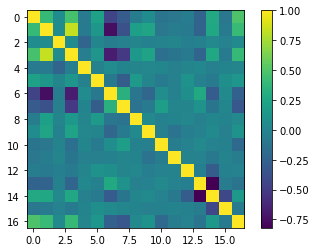

In [24]:
# correlation matrix
plt.imshow(M)
plt.colorbar()
plt.show()

In [25]:
# SVD using numpy function
U, E, VT = np.linalg.svd(M)

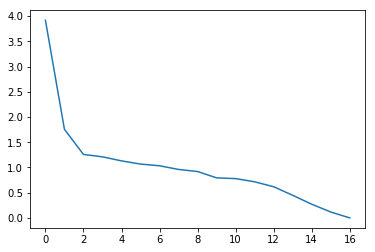

In [26]:
plt.plot(E)
plt.show()

In [27]:
P = np.dot(U[:,:2],np.diag(E[:2]))

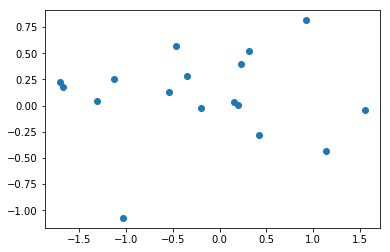

In [28]:
plt.plot(P[:,0], P[:,1],'o')
plt.show()

In [29]:
N = train.T
N.columns = N.iloc[0]
N = N.drop('ID')
N = N.astype(float)

In [30]:
# Takes 10-15 minutes with all of the data
N = N.corr()
N.head()

ID,4UnSIXBjGNIXFRcv3ShYRn,2FshzyETUyIXJyyzLFkEUJ,0jr0pJALTE1bWKrfeETeQT,4RCNwxAenSJ5B5CIdP7qIc,4uE2cYHmc598NBo1RA9VqS,6jgP6BmCQ0jQujPSWXgfYO,4F7mLHifcFEVyGTjSltj5V,0SGEY9ZQDyjyJUb7hWBdSp,5seiLYOVuSmkuBGoO9oWnb,6DPBjQxTeTX48XI0mh1Yce,...,1Agu4u8a8Qm28zq5JtwaVv,1gT8wgznnaFk0pdrpVxq5o,3yQCExCAd1v0HWoA1tPg2s,7GjktGoefJGTMMAfTtr51V,1NvIaZXTaXKTiq13Hg6fAZ,25wiOYoBrS6ITwcPGlTSXi,5oywMKXXVOvzRMoGiKg01f,6h0lmaVstb3szCpoXeSJOE,7DMeWL1rli1PPuFfKy4okd,4UtREbGYnd1nZLckEb5y8J
ID,,,,,,,,,,,,,,,,,,,,,
4UnSIXBjGNIXFRcv3ShYRn,1.000000,0.296033,-0.314661,-0.040063,0.588277,0.538958,0.148392,-0.100254,-0.010843,-0.249583,...,-0.314458,-0.060198,0.086622,0.548492,0.618566,0.300340,0.370114,-0.502038,-0.151584,0.171096
2FshzyETUyIXJyyzLFkEUJ,0.296033,1.000000,-0.308960,0.203917,0.616110,-0.193283,0.330708,0.182149,0.419319,-0.160908,...,-0.052477,-0.321805,-0.414719,0.284212,0.506266,0.361723,0.652553,-0.209203,0.567142,0.286573
0jr0pJALTE1bWKrfeETeQT,-0.314661,-0.308960,1.000000,0.363593,-0.123686,-0.073892,-0.198570,-0.014146,0.093608,0.288154,...,0.402640,0.127299,0.503227,-0.243052,-0.714204,-0.314224,-0.619279,0.574697,0.173192,-0.366941
4RCNwxAenSJ5B5CIdP7qIc,-0.040063,0.203917,0.363593,1.000000,0.268483,0.240576,0.257728,0.559276,0.018594,0.115395,...,0.659982,-0.254805,-0.105756,0.139998,-0.224964,0.552887,0.193802,-0.071582,0.233578,0.080850
4uE2cYHmc598NBo1RA9VqS,0.588277,0.616110,-0.123686,0.268483,1.000000,0.319414,0.554995,0.061496,0.198821,-0.016149,...,0.163598,-0.274766,-0.188326,0.278158,0.255181,0.419585,0.643378,-0.642537,0.470037,0.354081


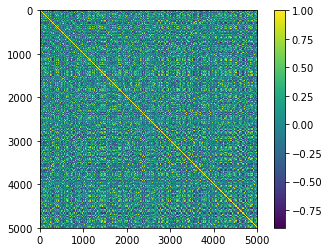

In [31]:
# Identifies how different songs correlate to each other, there is a fair amount of uniqueness among songs
plt.imshow(N)
plt.colorbar()
plt.show()

In [32]:
U, E, VT = np.linalg.svd(N)

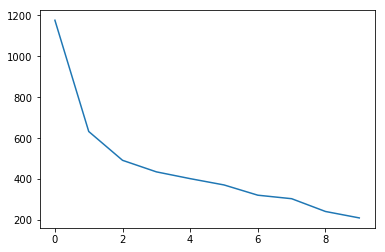

In [33]:
# Most of the variance can be explained using the first 8 or so components
plt.plot(E[:10])
plt.show()

In [34]:
P = np.dot(U[:,:2],np.diag(E[:2]))
print(P)

[[-23.89878696   6.3193738 ]
 [-16.79428202  -5.21143936]
 [ 22.59717797  -8.00901515]
 ..., 
 [ 28.42206106   1.04435793]
 [ -0.78754404 -17.01899423]
 [-17.42449254  -3.1041043 ]]


In [49]:
# plot first two principal components to get an idea of the shape of the data
_tools_to_show = 'box_zoom,pan,save,hover,resize,reset,tap,wheel_zoom'        
p = figure(plot_width=400, plot_height=400, title=None, tools=_tools_to_show)

# add a circle renderer with a size, color, and alpha
p.circle(P[:,0], P[:,1], size=4, color="navy", alpha=0.2)

# show the results
show(p)

In [ ]:
# SVM

In [50]:
# Further divide training and testing based on principal components
X_train, X_test, y_train, y_test = train_test_split(P, train['valence'], test_size = 0.2, random_state = 0)